In [19]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import robust_laplacian
import gpytoolbox as gpy
from scipy.spatial import ConvexHull
from scipy.sparse.linalg import eigsh

In [20]:
# Domain specification
x0, x1 = 0.0, 1.0
y0, y1 = 0.0, 1.0
t0, t1 = 0.0, 1.0

In [21]:
# Boundary Conditions
u_x0 = lambda t: tf.zeros_like(t)
u_y0 = lambda t: tf.zeros_like(t)
u_x1 = lambda t: tf.zeros_like(t)
u_y1 = lambda t: tf.zeros_like(t)

In [22]:
batch = 100
N_collocation = 10000
N_sensor = 32
max_deg = 2

In [23]:
k = 0.05

In [24]:
sensor_points = tf.convert_to_tensor(np.load('sensor_points.npy'), dtype=tf.float32)

In [25]:
# sensor_points = tf.random.uniform((1, N_sensor, 2), minval=[x0, y0], maxval=[x1, y1])
# np.save('sensor_points.npy', sensor_points.numpy())

In [26]:
def u_0(x, y, n, m, coefficients, k=k, L=1.0, H=1.0):
  u = 0.0*x
  for i in range(n):
    for j in range(m):
      # l_nm = (i*np.pi/L)**2 + (j*np.pi/H)**2
      u += tf.squeeze(coefficients[:, i:i+1, j:j+1], axis=-1) * tf.sin(np.pi * (i+1) * x / L) * tf.sin(np.pi * (j+1) * y / H )
  return u

In [27]:
def generateCollocationPoints(N_inputs, max_deg=10, x0=0.0, x1=1.0, y0=0.0, y1=1.0, t0=0.0, t1=1.0):
  pde_points = tf.random.uniform((N_inputs, 3), minval=[x0, y0, t0], maxval=[x1, y1, t1])
  ic_points = tf.random.uniform((N_inputs, 3), minval=[x0, y0, t0], maxval=[x1, y1, t0])
  bcx0 = tf.random.uniform((N_inputs, 3), minval=[x0, y0, t0], maxval=[x0, y1, t1])
  bcx1 = tf.random.uniform((N_inputs, 3), minval=[x1, y0, t0], maxval=[x1, y1, t1])
  bcy0 = tf.random.uniform((N_inputs, 3), minval=[x0, y0, t0], maxval=[x1, y0, t1])
  bcy1 = tf.random.uniform((N_inputs, 3), minval=[x0, y1, t0], maxval=[x1, y1, t1])

  bc_points = tf.concat([bcx0, bcx1, bcy0, bcy1], axis=0)

  x_sensor = sensor_points[:, :, 0]
  y_sensor = sensor_points[:, :, 1]

  coefficients = tf.random.normal([N_inputs, max_deg, max_deg])

  u_i = u_0(ic_points[:, 0:1], ic_points[:, 1:2], max_deg, max_deg, coefficients)
  ic_points = tf.concat([ic_points, u_i], axis=1)

  u_sensor_points = u_0(x_sensor, y_sensor, max_deg, max_deg, coefficients)

  return pde_points, ic_points, bc_points, u_sensor_points, coefficients

In [28]:
pde_points, ic_points, bc_points, u_sensor_points, coefficients = generateCollocationPoints(N_collocation, max_deg=max_deg)

In [29]:
# p1 = tf.random.uniform((100, 3), minval=[x0 + 0.1 * np.random.rand(), y0 + 0.1 * np.random.rand(), t0], maxval=[x0 + 0.1 * np.random.rand(), y0 + 0.1 * np.random.rand(), t1])
# p2 = tf.random.uniform((100, 3), minval=[x1 - 0.1 * np.random.rand(), y0 + 0.1 * np.random.rand(), t0], maxval=[x1 - 0.1 * np.random.rand(), y0 + 0.1 * np.random.rand(), t1])
# p3 = tf.random.uniform((100, 3), minval=[x0 + 0.1 * np.random.rand(), y1 - 0.1 * np.random.rand(), t0], maxval=[x0 + 0.1 * np.random.rand(), y1 - 0.1 * np.random.rand(), t1])
# p4 = tf.random.uniform((100, 3), minval=[x1 - 0.1 * np.random.rand(), y1 - 0.1 * np.random.rand(), t0], maxval=[x1 - 0.1 * np.random.rand(), y1 - 0.1 * np.random.rand(), t1])
# pde_points = tf.concat([pde_points[400:], p1, p2, p3, p4], axis=0)

In [30]:
print(pde_points.shape, ic_points.shape, bc_points.shape)
print(u_sensor_points.shape)
print(coefficients.shape)

(10000, 3) (10000, 4) (40000, 3)
(10000, 32)
(10000, 2, 2)


In [31]:
modes = 8

In [32]:
def eigens(pts, k=10):
  L, M = robust_laplacian.point_cloud_laplacian(pts.numpy())
  eigenvalues, eigenvectors = eigsh(L, k=k, M=M, which='LM', sigma=0.0, tol=1e-6)
  return eigenvalues, eigenvectors, M

In [34]:
def spectrals(efuncs):
  phi = efuncs
  phi_dagger = tf.matmul(tf.linalg.inv(tf.matmul(tf.transpose(phi), phi)), tf.transpose(phi))
  return phi, phi_dagger

In [ ]:
x, y = pde_points[:, 0], pde_points[:, 1]
pts = tf.stack([x, y, tf.zeros_like(x)], axis=-1)
evals, efuncs, M = eigens(pts, k=modes)
M = tf.convert_to_tensor(M.toarray(), dtype=tf.float32)

QhullError: QH6154 Qhull precision error: Initial simplex is flat (facet 1 is coplanar with the interior point)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 1873638018  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _max-width  1  Error-roundoff 1.4e-15  _one-merge 9.7e-15
  _near-inside 4.9e-14  Visible-distance 2.8e-15  U-max-coplanar 2.8e-15
  Width-outside 5.5e-15  _wide-facet 1.7e-14  _maxoutside 1.1e-14

The input to qhull appears to be less than 3 dimensional, or a
computation has overflowed.

Qhull could not construct a clearly convex simplex from points:
- p7125(v4):  0.86     1 1e-10
- p9283(v3):  0.74 0.0002 1e-10
- p7577(v2):     1  0.62 1e-10
- p3987(v1): 8.9e-06   0.5 1e-10

The center point is coplanar with a facet, or a vertex is coplanar
with a neighboring facet.  The maximum round off error for
computing distances is 1.4e-15.  The center point, facets and distances
to the center point are as follows:

center point   0.6498   0.5306    1e-10

facet p9283 p7577 p3987 distance=    0
facet p7125 p7577 p3987 distance=    0
facet p7125 p9283 p3987 distance=    0
facet p7125 p9283 p7577 distance=    0

These points either have a maximum or minimum x-coordinate, or
they maximize the determinant for k coordinates.  Trial points
are first selected from points that maximize a coordinate.

The min and max coordinates for each dimension are:
  0:  8.941e-06         1  difference=    1
  1:  0.0001986         1  difference= 0.9998
  2:     1e-10     1e-10  difference=    0

If the input should be full dimensional, you have several options that
may determine an initial simplex:
  - use 'QJ'  to joggle the input and make it full dimensional
  - use 'QbB' to scale the points to the unit cube
  - use 'QR0' to randomly rotate the input for different maximum points
  - use 'Qs'  to search all points for the initial simplex
  - use 'En'  to specify a maximum roundoff error less than 1.4e-15.
  - trace execution with 'T3' to see the determinant for each point.

If the input is lower dimensional:
  - use 'QJ' to joggle the input and make it full dimensional
  - use 'Qbk:0Bk:0' to delete coordinate k from the input.  You should
    pick the coordinate with the least range.  The hull will have the
    correct topology.
  - determine the flat containing the points, rotate the points
    into a coordinate plane, and delete the other coordinates.
  - add one or more points to make the input full dimensional.


: 

In [ ]:
print(evals)

[8.14004330e-14 9.48244143e+00 9.49285743e+00 1.90152135e+01
 3.79274054e+01 3.80166334e+01 4.75814431e+01 4.76362805e+01]


In [333]:
phi, phi_dagger = spectrals(efuncs)

In [334]:
def L2Error(u_true, u_pred):
  return tf.norm(u_true - u_pred) / tf.norm(u_true)

In [335]:
class Normalize(tf.keras.layers.Layer):
  def __init__(self, xmin, xmax, name=None, **kwargs):
    super(Normalize, self).__init__(name=name)
    self.xmin = xmin
    self.xmax = xmax
    super(Normalize, self).__init__(**kwargs)

  def call(self, inputs):
    return 2.0*(inputs-self.xmin)/(self.xmax-self.xmin)-1.0

  def get_config(self):
    config = super(Normalize, self).get_config()
    config.update({'xmin': self.xmin, 'xmax': self.xmax})
    return config

In [336]:
pmin = tf.constant([x0, y0, t0], dtype=tf.float32)
pmax = tf.constant([x1, y1, t1], dtype=tf.float32)

In [337]:
class ApproximationBlock(tf.keras.layers.Layer):
  def __init__(self, width, modes=10, name=None, **kwargs):
    super(ApproximationBlock, self).__init__(name=name)
    self.modes = modes
    self.width = width
    self.dense_tanh = tf.keras.layers.Dense(width, activation='tanh')
    self.dense_linear = tf.keras.layers.Dense(width, activation='linear')

  def call(self, inputs, t, evals, phi, phi_dagger, M):
    encoded_in = tf.matmul(phi_dagger, tf.matmul(M, inputs))
    R = self.dense_tanh(encoded_in)
    R_out = self.dense_linear(R)
    exp_term = tf.exp(-k * tf.expand_dims(t, axis=-1) * evals)

    # R_out = exp_term @ R_out
    decoded_out=phi@R_out
    # decoded_out = tf.einsum('ij, ik -> ik', phi, R_out)
    return decoded_out

In [338]:
class LaplaceBlock(tf.keras.layers.Layer):
  def __init__(self, width, modes=10, name=None, **kwargs):
    super(LaplaceBlock, self).__init__(name=name)
    self.modes = modes
    self.width = width
    self.weights_l = tf.keras.layers.Dense(width, use_bias=False)
    self.bias_l = self.add_weight(name='bias', shape=(width,), initializer='zeros', trainable=True)

    self.approx_block = ApproximationBlock(width, modes=modes)

  def call(self, v_prev, t, evals, phi, phi_dagger, M):
    transformed_v = self.weights_l(v_prev) + self.bias_l
    N_out = self.approx_block(transformed_v, t, evals, phi, phi_dagger, M)

    out = tf.keras.layers.Activation('tanh')(self.weights_l(v_prev) + self.bias_l + N_out)
    return out

In [339]:
class SpectralModel(tf.keras.Model):
  def __init__(self, width, depth, n_sensor, **kwargs):
    super(SpectralModel, self).__init__(**kwargs)
    self.width = width
    self.depth = depth
    self.n_sensor = n_sensor
    #self.input = tf.keras.layers.Input(shape=(4,))
    self.dense0 = tf.keras.layers.Dense(width, activation='tanh')
    self.dense1 = tf.keras.layers.Dense(width, activation='tanh')
    self.dense2 = tf.keras.layers.Dense(width, activation='linear')
    self.dense3 = tf.keras.layers.Dense(width, activation='tanh')
    self.dense4 = tf.keras.layers.Dense(1, use_bias=False)
    self.dense5 = tf.keras.layers.Dense(width, activation='tanh')
    self.laplace_block = LaplaceBlock(width, modes=10)
    self.pmin = tf.constant([x0, y0, t0], dtype=tf.float32)
    self.pmax = tf.constant([x1, y1, t1], dtype=tf.float32)
    self.normalize = Normalize(self.pmin, self.pmax)

  def call(self, pde_pts, u_sensor_pts, evals, phi, phi_dagger, M, training=False):
    b = self.normalize(pde_pts)
    b = self.dense0(b)
    for i in range(self.depth):
      b = self.dense1(b)
    trunk_out = self.dense2(b)

    t = pde_pts[:,2]
    v = u_sensor_pts
    v = self.dense3(v)
    for i in range(self.depth):
      v = self.laplace_block(v, t, evals, phi, phi_dagger, M)

    branch_out = self.dense5(v)

    out = tf.keras.layers.Multiply()([trunk_out, branch_out])
    out = self.dense4(out)

    return out

In [340]:
model = SpectralModel(50, 4, N_sensor)

In [341]:
output = model(pde_points, u_sensor_points, evals, phi, phi_dagger, M)

In [342]:
output

<tf.Tensor: shape=(10000, 1), dtype=float32, numpy=
array([[ 0.07279884],
       [ 0.05283552],
       [-0.02034828],
       ...,
       [ 0.06052572],
       [ 0.03462355],
       [-0.02973537]], dtype=float32)>

In [343]:
@tf.function
def train_step(model, optimizer, pde_pts, ic_pts, bc_pts, u_inputs, coefficients, evals, phi, phi_dagger, M, xmin=0.0, xmax=1.0, ymin=0.0, ymax=1.0, tmax=1.0, max_deg=10):
  x, y, t = pde_pts[:, 0], pde_pts[:, 1], pde_pts[:, 2]
  xi, yi, ti, ui = ic_pts[:, 0], ic_pts[:, 1], ic_pts[:, 2], ic_pts[:, 3]
  with tf.GradientTape(persistent=True) as tape:
    tape.watch(pde_pts)
    u_pde = model(pde_pts, u_inputs, evals, phi, phi_dagger, M)

    grads = tape.gradient(u_pde, pde_pts)

    ux = grads[:, 0]
    uy = grads[:, 1]
    ut = grads[:, 2]

    uxx = tape.gradient(ux, pde_pts)[:, 0]
    uyy = tape.gradient(uy, pde_pts)[:, 1]

    eqn = ut - k * (uxx + uyy)

    PDE_loss = tf.reduce_mean(eqn**2)

    u_ic = tf.squeeze(model(ic_pts[:,0:3], u_inputs, evals, phi, phi_dagger, M))
    IC_loss = tf.reduce_mean((u_ic - ui)**2)

    bcx0, bcx1, bcy0, bcy1 = tf.split(bc_pts, 4, axis=0)
    u_bcx0 = tf.squeeze(model(bcx0, u_inputs, evals, phi, phi_dagger, M))
    u_bcx1 = tf.squeeze(model(bcx1, u_inputs, evals, phi, phi_dagger, M))
    u_bcy0 = tf.squeeze(model(bcy0, u_inputs, evals, phi, phi_dagger, M))
    u_bcy1 = tf.squeeze(model(bcy1, u_inputs, evals, phi, phi_dagger, M))

    BC_loss = tf.reduce_mean((u_bcx0)**2) + tf.reduce_mean((u_bcx1)**2) + tf.reduce_mean((u_bcy0)**2) + tf.reduce_mean((u_bcy1)**2)

    loss = PDE_loss + IC_loss + BC_loss

  grads = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(grads, model.trainable_variables))
  return loss, PDE_loss, IC_loss, BC_loss

In [344]:
def u_analytic(x, y, t, coefficients, diffusion=k, max_deg=10, L=1.0, H=1.0):
  u = 0.0*x
  for i in range(max_deg):
    for j in range(max_deg):
      l_nm = ((i+1)*np.pi/L)**2 + ((j+1)*np.pi/H)**2
      u += tf.squeeze(coefficients[:, i:i+1, j:j+1], axis=-1) * tf.sin(np.pi * (i+1) * x / L) * tf.sin(np.pi * (j+1) * y / H ) * tf.exp(-diffusion * l_nm * t)
  return u

In [345]:
def train(model, optimizer, pde_pts, ic_pts, bc_pts, u_sensor_points, coefficients, evals, phi, phi_dagger, M, tmax=1.0, max_deg=10, epochs=1000):
  losses = []
  for epoch in range(epochs):
    loss, PDE_loss, IC_loss, BC_loss = train_step(model, optimizer, pde_pts, ic_pts, bc_pts, u_sensor_points, coefficients, evals, phi, phi_dagger, M, tmax=tmax, max_deg=max_deg)
    losses.append(loss)
    if epoch % 100 == 0:
      x, y, t = pde_points[:, 0], pde_points[:, 1], pde_points[:, 2]
      #error = tf.abs(model(pde_pts, u_sensor_points, evals, phi, phi_dagger, M) - u_analytic(x, y, t, coefficients=coefficients, max_deg=max_deg))
      print(f'Epoch {epoch} - Loss {loss.numpy()} - PDE loss {PDE_loss.numpy()} - IC loss {IC_loss.numpy()} - BC loss {BC_loss.numpy()}')

  return losses

In [346]:
model = SpectralModel(50, 4, N_sensor)

In [347]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=5e-5,
    decay_steps=7500,
    decay_rate=0.5)

In [348]:
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

In [349]:
model(pde_points, u_sensor_points, evals, phi, phi_dagger, M)

<tf.Tensor: shape=(10000, 1), dtype=float32, numpy=
array([[-0.07534084],
       [-0.0170933 ],
       [ 0.02230649],
       ...,
       [-0.0952715 ],
       [-0.01069598],
       [ 0.04746224]], dtype=float32)>

In [350]:
model.load_weights('dnet2dheat.weights.h5')

In [351]:
losses = train(model, optimizer, pde_points, ic_points, bc_points, u_sensor_points, coefficients, evals, phi, phi_dagger, M, tmax=t1, max_deg=max_deg, epochs=15000)
losses = [l.numpy() for l in losses]

Epoch 0 - Loss 0.0007609689491800964 - PDE loss 0.00048010150203481317 - IC loss 0.00014135929814074188 - BC loss 0.00013950816355645657
Epoch 100 - Loss 0.0006985232466831803 - PDE loss 0.0004354261327534914 - IC loss 0.0001216037489939481 - BC loss 0.00014149342314340174
Epoch 200 - Loss 0.0006780473049730062 - PDE loss 0.0004200564872007817 - IC loss 0.00011647443898255005 - BC loss 0.0001415163278579712
Epoch 300 - Loss 0.0006638569757342339 - PDE loss 0.00040904010529629886 - IC loss 0.00011369830463081598 - BC loss 0.00014111859491094947
Epoch 400 - Loss 0.0006521644536405802 - PDE loss 0.00040026140050031245 - IC loss 0.00011121752322651446 - BC loss 0.00014068551536183804
Epoch 500 - Loss 0.0006422655424103141 - PDE loss 0.00039281888166442513 - IC loss 0.00010918204498011619 - BC loss 0.00014026461576577276
Epoch 600 - Loss 0.0006353287608362734 - PDE loss 0.0003864688042085618 - IC loss 0.00010777220450108871 - BC loss 0.00014108778850641102
Epoch 700 - Loss 0.000625753193162

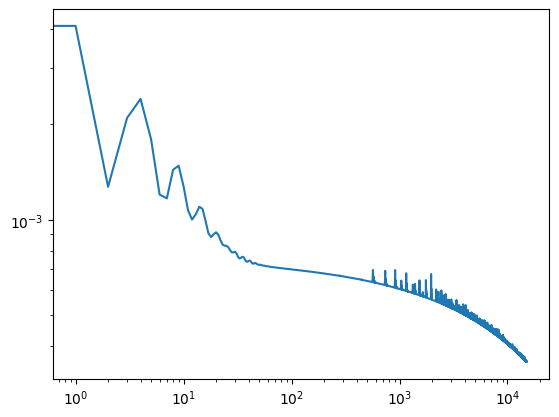

In [352]:
plt.plot(losses)
plt.xscale('log')
plt.yscale('log')

In [353]:
model.save_weights('dnet2dheat.weights.h5')

In [354]:
model.load_weights('dnet2dheat.weights.h5')

In [355]:
test_pde, test_ic, test_bc, test_u_sensor, test_coeffs = generateCollocationPoints(N_collocation, max_deg=max_deg)

In [356]:
x, y, t = test_pde[:, 0], test_pde[:, 1], test_pde[:, 2]

test_pts = tf.stack([x, y, tf.zeros_like(x)], axis=-1)
test_evals, test_efuncs, test_M = eigens(test_pts, k=modes)
test_M = tf.convert_to_tensor(test_M.toarray(), dtype=tf.float32)

test_phi, test_phi_dagger = spectrals(test_efuncs)

test_coeffs = tf.random.normal([1, max_deg, max_deg])

X_sens = sensor_points[:, :, 0:1]
Y_sens = sensor_points[:, :, 1:2]

test_u_sensor = tf.tile(tf.squeeze(u_0(X_sens, Y_sens, max_deg, max_deg, test_coeffs), axis=2), multiples=[N_collocation, 1])

u_pred = tf.squeeze(model(test_pde, test_u_sensor, test_evals, test_phi, test_phi_dagger, test_M))
# Evaluate true solution
u_true = tf.squeeze(u_analytic(x, y, t, test_coeffs, max_deg=max_deg))

In [357]:
print(f"Test MAE: {tf.reduce_mean(tf.abs(u_pred - u_true))}")
print(f"Test L2: {L2Error(u_true, u_pred)}")

Test MAE: 0.002443017903715372
Test L2: 0.005236238241195679


In [358]:
def set_axes_equal_tensorflow(ax, x, y, z):
    x = tf.reshape(x, [-1]).numpy()
    y = tf.reshape(y, [-1]).numpy()
    z = tf.reshape(z, [-1]).numpy()

    x_min, x_max = x.min(), x.max()
    y_min, y_max = y.min(), y.max()
    z_min, z_max = z.min(), z.max()

    x_range = x_max - x_min
    y_range = y_max - y_min
    z_range = z_max - z_min

    max_range = max(x_range, y_range, z_range)

    x_middle = 0.5 * (x_max + x_min)
    y_middle = 0.5 * (y_max + y_min)
    z_middle = 0.5 * (z_max + z_min)

    ax.set_xlim([x_middle - max_range/2, x_middle + max_range/2])
    ax.set_ylim([y_middle - max_range/2, y_middle + max_range/2])
    ax.set_zlim([z_middle - max_range/2, z_middle + max_range/2])


In [359]:

def modelResults(model, true, t_steps=10, tmax=1.0, load=False, saveplots=False):
  if load:
    model.load_weights(load)

  x = np.linspace(x0, x1, 100, dtype=np.float32)
  y = np.linspace(y0, y1, 100, dtype=np.float32)
  X, Y = np.meshgrid(x, y)

  coeffs = tf.random.normal([1, max_deg, max_deg])

  X_sens = sensor_points[:, :, 0:1]
  Y_sens = sensor_points[:, :, 1:2]

  u_sens_pts = tf.tile(tf.squeeze(u_0(X_sens, Y_sens, max_deg, max_deg, coeffs), axis=2), multiples=[10000, 1])
  vmin, vmax = 0.0, 0.0
  absmin, absmax = 0.0, 0.0
  for i in range(t_steps+1):
    X = tf.reshape(X, [-1])
    Y = tf.reshape(Y, [-1])

    t = tf.ones_like(X) * (i * tmax / t_steps)
    print(f"Current t-value: {i * tmax / t_steps}")

    u_actual = tf.squeeze(true(X, Y, t, coeffs, max_deg=max_deg))
    U_actual = tf.reshape(u_actual, [100, 100])

    test_pts = tf.stack([X, Y, t], axis=-1)
    test_evals, test_efuncs, test_M = eigens(tf.squeeze(test_pts), k=modes)
    test_M = tf.convert_to_tensor(test_M.toarray(), dtype=tf.float32)

    test_phi, test_phi_dagger = spectrals(test_efuncs)

    u_pred = tf.squeeze(model(test_pts, u_sens_pts, test_evals, test_phi, test_phi_dagger, test_M))
    U_pred = tf.reshape(u_pred, [100, 100])

    u_abs = tf.abs(u_actual - u_pred)

    print(f"MAE error at t={i * tmax / t_steps}: {tf.reduce_mean(u_abs): .4f}")

    U_abs = tf.reshape(u_abs, [100, 100])

    fig = plt.figure(figsize=(16, 6))

    ax_abs = fig.add_subplot(131)
    ax1 = fig.add_subplot(132)
    ax2 = fig.add_subplot(133)

    X = tf.reshape(X, [100, 100])
    Y = tf.reshape(Y, [100, 100])

    uA = U_actual.numpy()
    uP = U_pred.numpy()

    if i == 0:
      vmin = min(uA.min(), uP.min())
      vmax = max(uA.max(), uP.max())
      U_abs = U_abs.numpy()
      absmin = U_abs.min()
      absmax = U_abs.max()

    ax_abs.contourf(X, Y, U_abs, 20, vmin = absmin, vmax = absmax, cmap='coolwarm')
    ax1.contourf(X, Y, U_actual, 20, vmin = vmin, vmax=vmax, cmap='coolwarm')
    ax2.contourf(X, Y, U_pred, 20, vmin = vmin, vmax=vmax, cmap='coolwarm')

    plt.colorbar(ax_abs.contourf(X, Y, U_abs, 20, vmin = absmin, vmax = absmax, cmap='coolwarm'))
    plt.colorbar(ax1.contourf(X, Y, U_actual, 20, vmin = vmin, vmax=vmax, cmap='coolwarm'))
    plt.colorbar(ax2.contourf(X, Y, U_pred, 20, vmin = vmin, vmax=vmax, cmap='coolwarm'))

    if saveplots:
      plt.savefig(f'heat_results_{i}.png')
  plt.show()

Current t-value: 0.0
MAE error at t=0.0:  0.0045
Current t-value: 0.1
MAE error at t=0.1:  0.0023
Current t-value: 0.2
MAE error at t=0.2:  0.0023
Current t-value: 0.3
MAE error at t=0.3:  0.0023
Current t-value: 0.4
MAE error at t=0.4:  0.0022
Current t-value: 0.5
MAE error at t=0.5:  0.0016
Current t-value: 0.6
MAE error at t=0.6:  0.0018
Current t-value: 0.7
MAE error at t=0.7:  0.0016
Current t-value: 0.8
MAE error at t=0.8:  0.0018
Current t-value: 0.9
MAE error at t=0.9:  0.0021
Current t-value: 1.0
MAE error at t=1.0:  0.0021


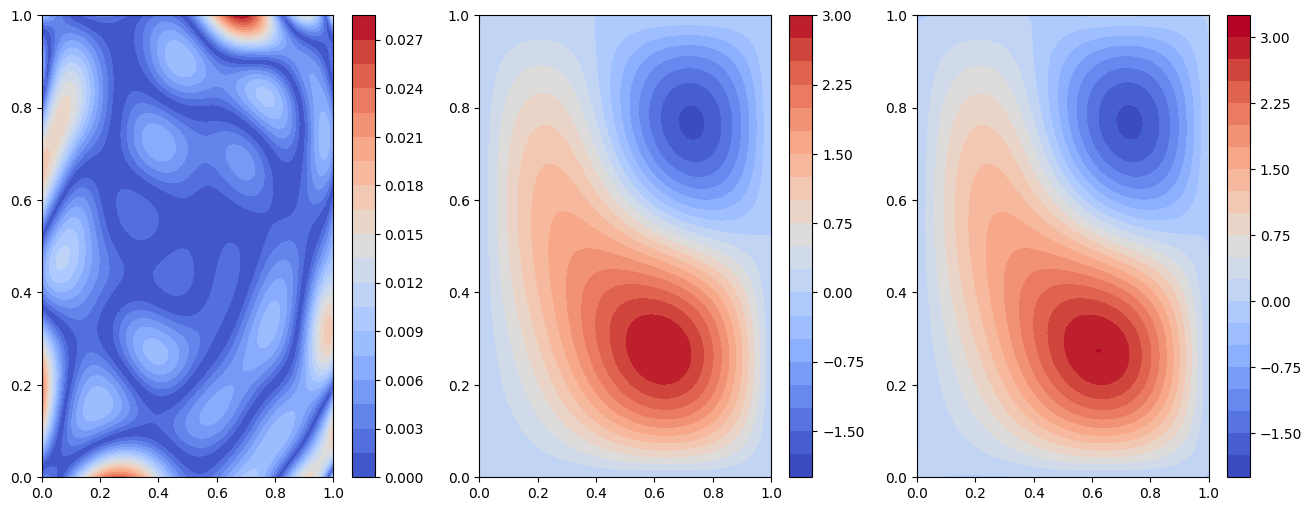

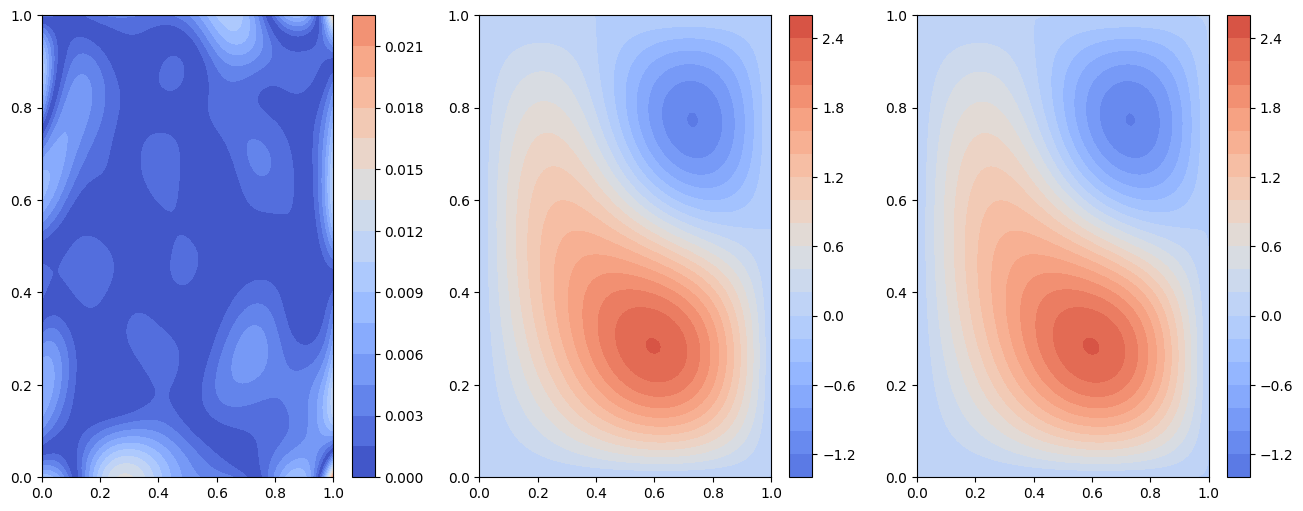

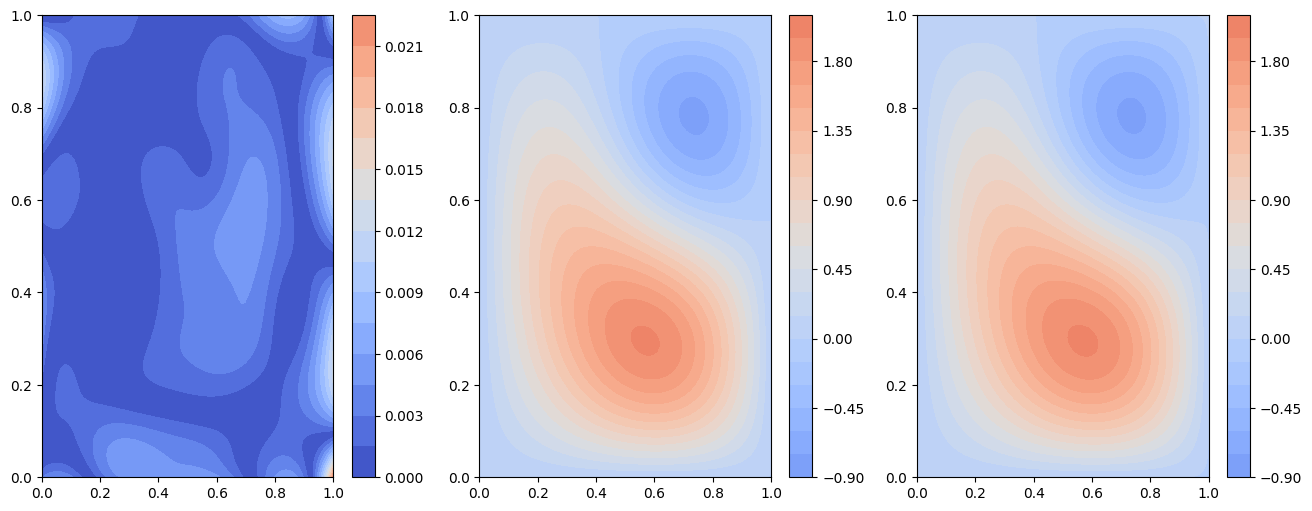

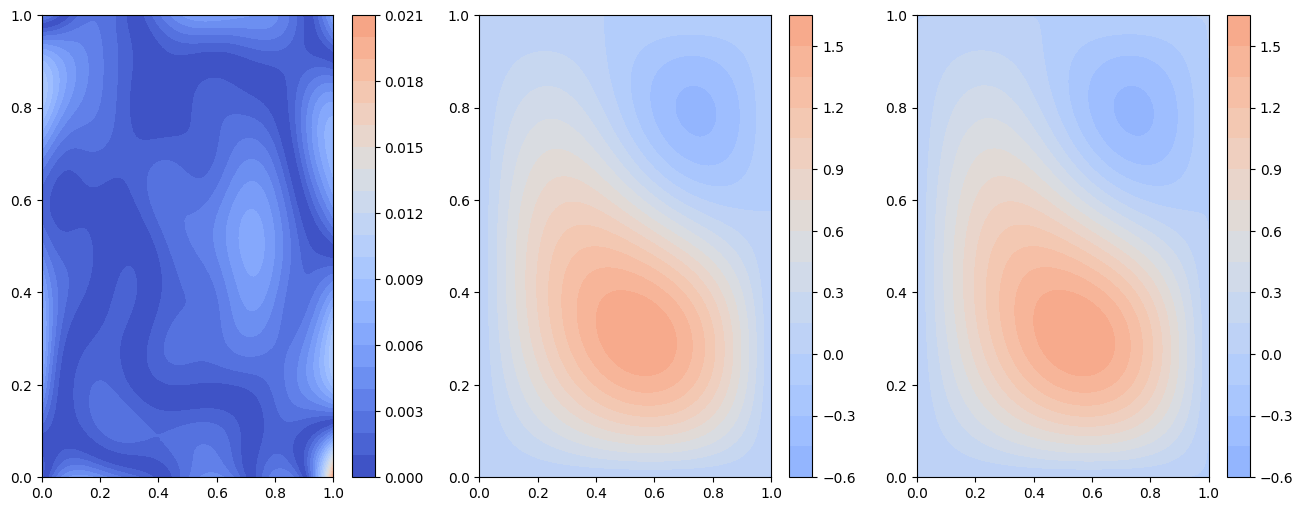

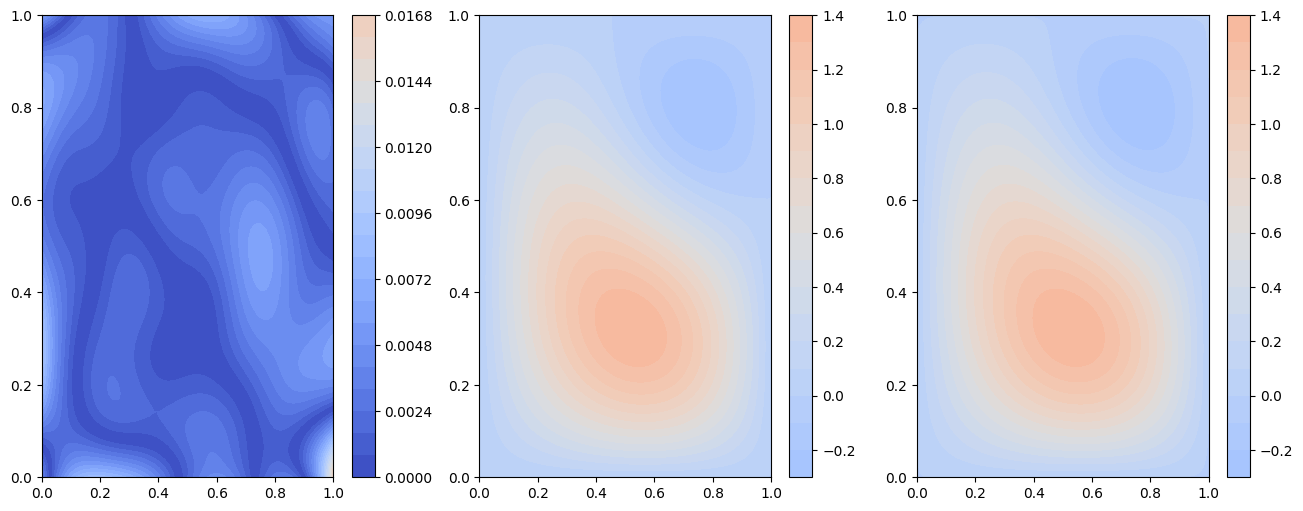

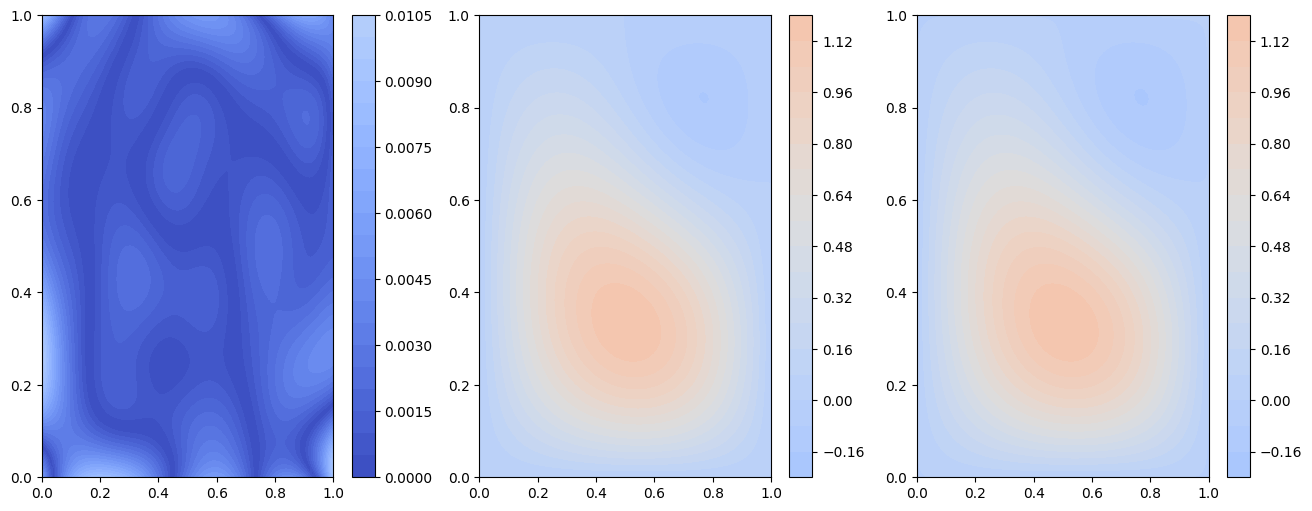

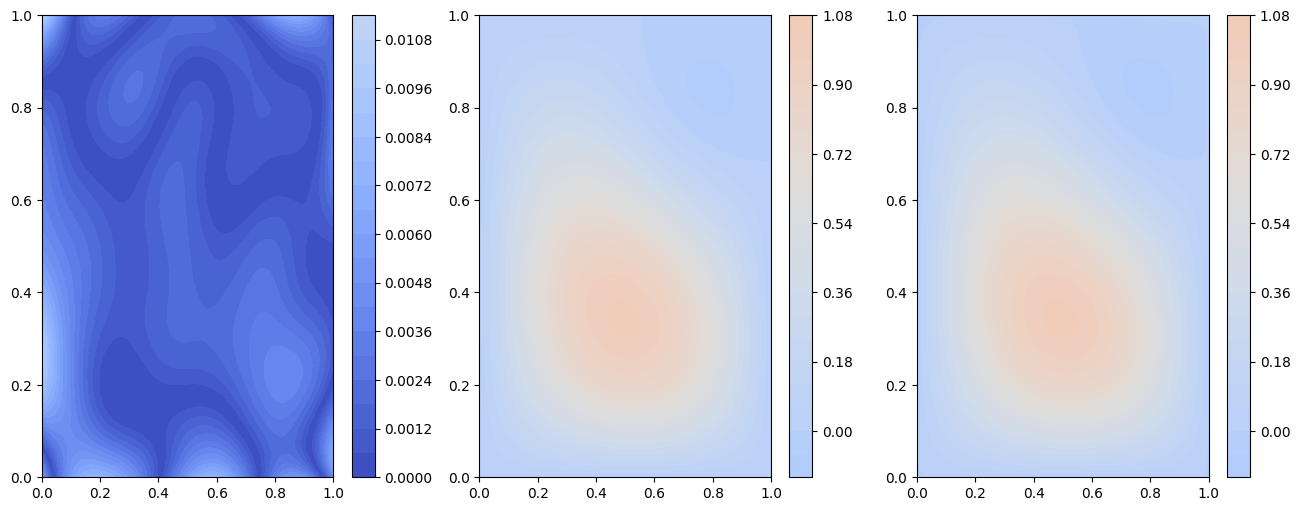

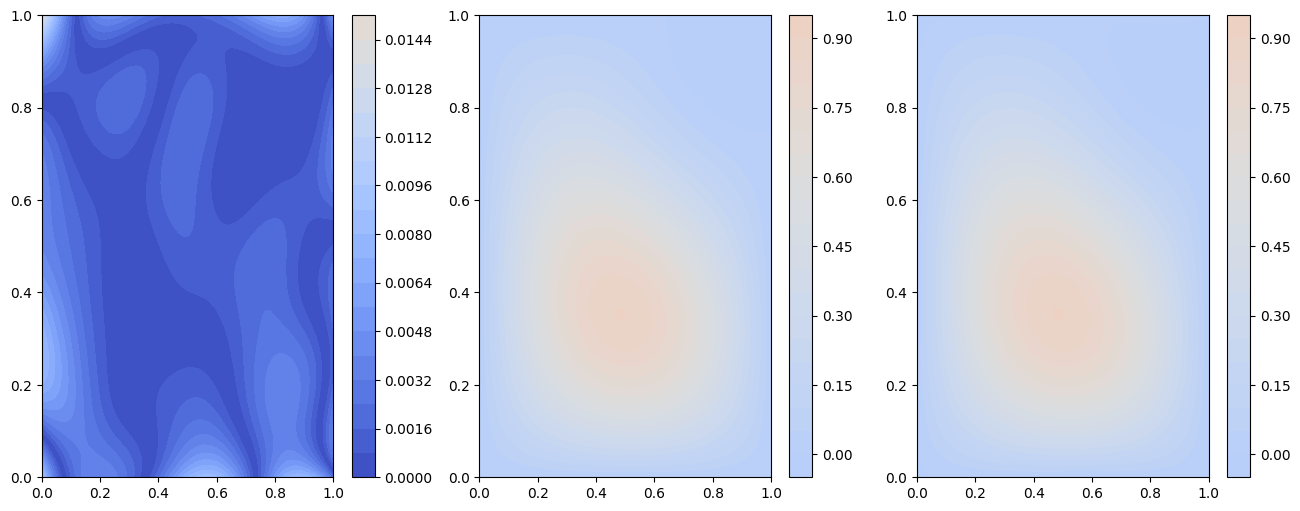

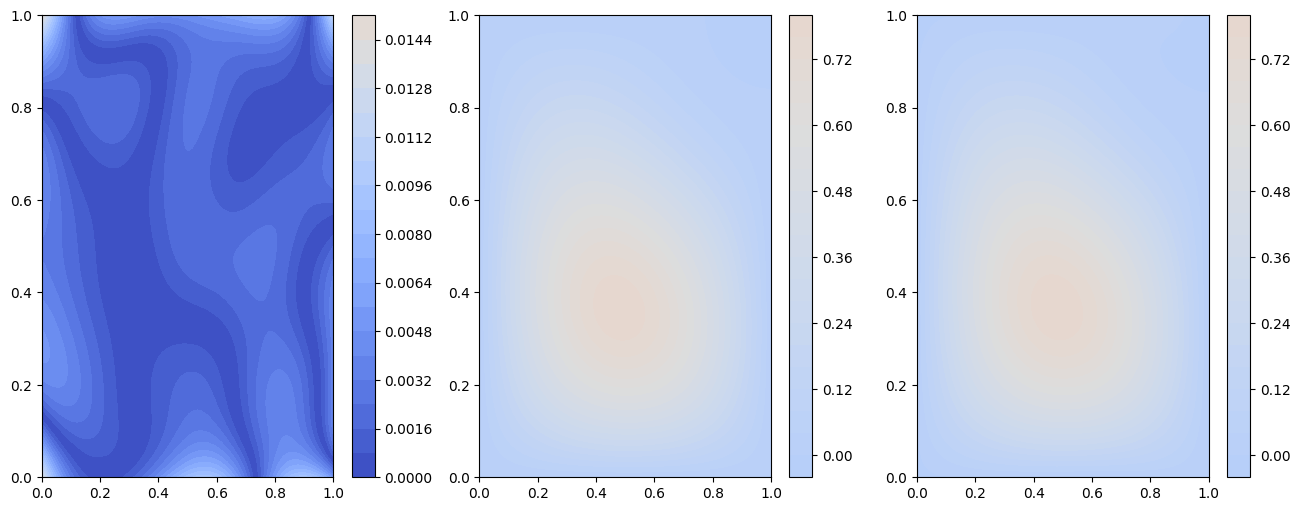

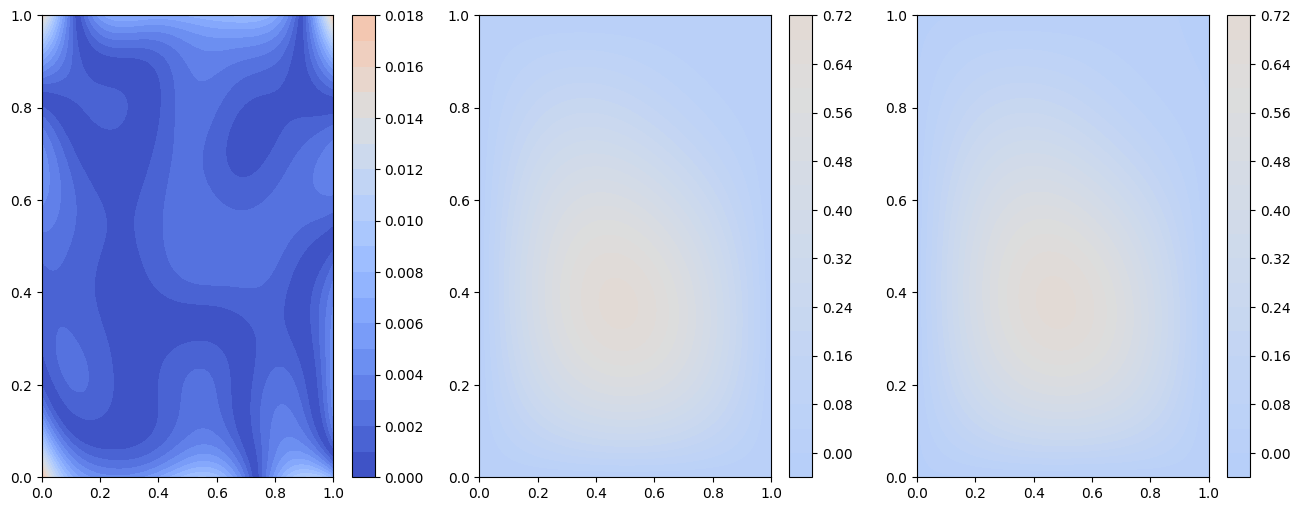

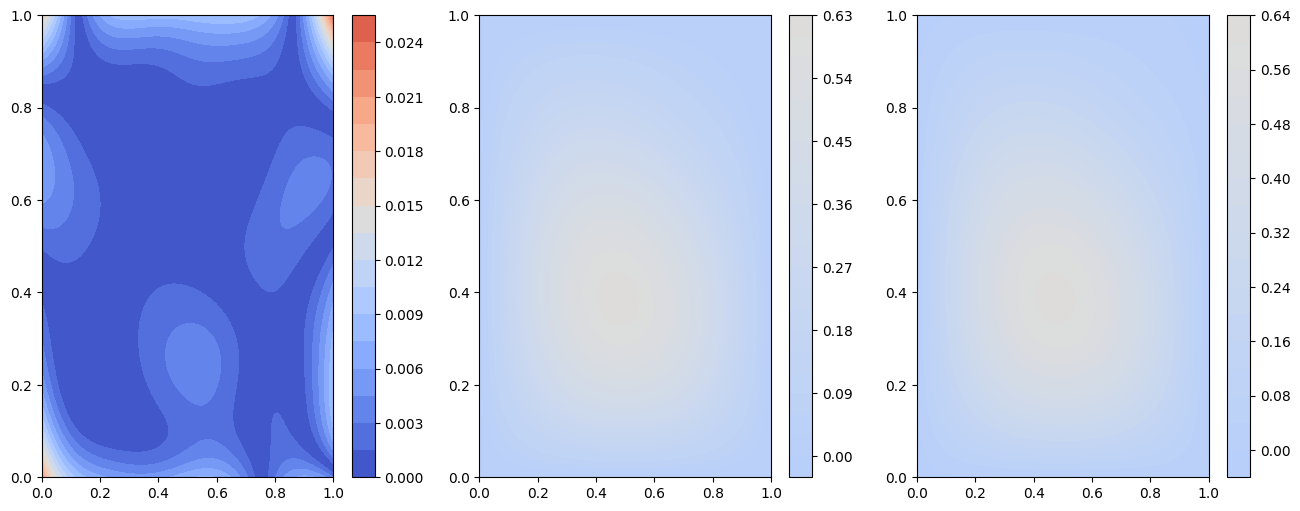

In [360]:
modelResults(model, u_analytic)